<a href="https://colab.research.google.com/github/romerofernandes/power_consumption_predict/blob/main/power_consumption_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importações

###Bibliotecas

In [541]:
#Analise de dados
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler

In [542]:
#Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [543]:
#Função para colocar os valores sobre as barras nos gráficos de barras
def values_text(graf):
    for bar in graf.patches:
        graf.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() * 1.01,
            round(bar.get_height(),1),
            horizontalalignment='center',
            color= 'black'
            )

In [544]:
#Modelagem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, r_regression

In [545]:
#! pip install scikit-optimize

In [546]:
#Otimização de hiperparametros 
#Necessario instalar scikit-optimize: ! pip install scikit-optimize
#from skopt import BayesSearchCV
#from skopt.space import Integer

In [547]:
#Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [548]:
#Análise dos modelos
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

###Dados

####Dados de consumo

In [549]:
#Dados sobre o consumo de energia elétrica

df_consumption = pd.read_csv('/content/power_usage_2016_to_2020.csv', 
                             parse_dates= ['StartDate'])

In [550]:
df_consumption.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [551]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   StartDate    35952 non-null  datetime64[ns]
 1   Value (kWh)  35952 non-null  float64       
 2   day_of_week  35952 non-null  int64         
 3   notes        35952 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [552]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_consumption.duplicated().sum()}")

Valores duplicados: 0


In [553]:
df_consumption.notes.unique()

array(['weekday', 'weekend', 'vacation', 'COVID_lockdown'], dtype=object)

In [554]:
df_consumption.drop(columns=['notes','day_of_week'], inplace=True)

In [555]:
df_consumption.sort_values(by='StartDate').head()

,StartDate,Value (kWh)
0,2016-01-06 00:00:00,1.057
1,2016-01-06 01:00:00,1.171
2,2016-01-06 02:00:00,0.560
3,2016-01-06 03:00:00,0.828
4,2016-01-06 04:00:00,0.932


In [556]:
#Renomeando a coluna de consumo
df_consumption.rename(columns={'Value (kWh)': 'consumption', 'StartDate':'Date'}, inplace=True)

In [557]:
df_consumption = df_consumption.groupby(df_consumption.Date.dt.date).sum().reset_index()

In [558]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1498 non-null   object 
 1   consumption  1498 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.5+ KB


In [559]:
df_consumption.Date = pd.to_datetime(df_consumption.Date)

In [560]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1498 non-null   datetime64[ns]
 1   consumption  1498 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.5 KB


In [561]:
df_consumption.describe()

,consumption
count,1498.000000
mean,21.399148
std,12.635139
min,4.610000
25%,10.828750
50%,16.833500
75%,30.726250
max,78.225300


####Dados sobre o tempo

In [562]:
#Dados sobre tempo (temperatura, pressão, preciptação...)
df_weather = pd.read_csv('/content/weather_2016_2020_daily.csv', parse_dates=['Date'])

In [563]:
df_weather.head()

,Date,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
0,2016-01-06,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
1,2016-02-06,2,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2,2016-03-06,3,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
3,2016-04-06,4,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
4,2016-05-06,5,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4


In [564]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1552 non-null   datetime64[ns]
 1   Day          1552 non-null   int64         
 2   Temp_max     1552 non-null   int64         
 3   Temp_avg     1552 non-null   float64       
 4   Temp_min     1552 non-null   int64         
 5   Dew_max      1552 non-null   int64         
 6   Dew_avg      1552 non-null   float64       
 7   Dew_min      1552 non-null   int64         
 8   Hum_max      1552 non-null   int64         
 9   Hum_avg      1552 non-null   float64       
 10  Hum_min      1552 non-null   int64         
 11  Wind_max     1552 non-null   int64         
 12  Wind_avg     1552 non-null   float64       
 13  Wind_min     1552 non-null   int64         
 14  Press_max    1552 non-null   float64       
 15  Press_avg    1552 non-null   float64       
 16  Press_

In [565]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_weather.duplicated().sum()}")

Valores duplicados: 0


###Dataset para modelagem

In [566]:
df_cons_pred = df_weather.merge(df_consumption, on='Date', how='right')

In [567]:
df_cons_pred.isnull().sum()

Date           0
Day            0
Temp_max       0
Temp_avg       0
Temp_min       0
Dew_max        0
Dew_avg        0
Dew_min        0
Hum_max        0
Hum_avg        0
Hum_min        0
Wind_max       0
Wind_avg       0
Wind_min       0
Press_max      0
Press_avg      0
Press_min      0
Precipit       0
day_of_week    0
consumption    0
dtype: int64

In [568]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_cons_pred.duplicated().sum()}")

Valores duplicados: 0


##Analises dos dados

###Analise correlação

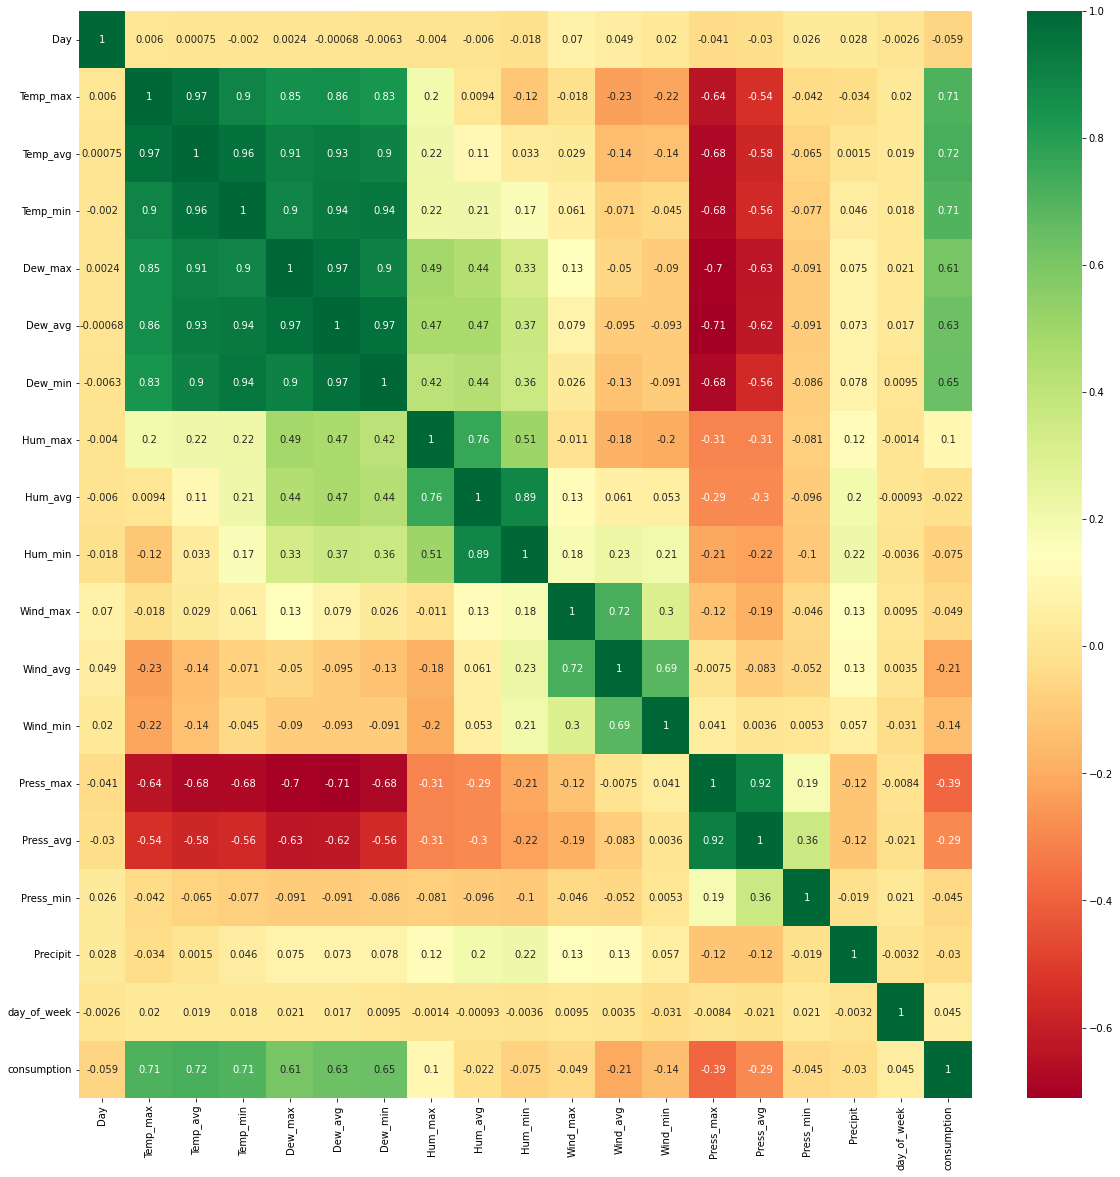

In [569]:
#correlacao linear
#get correlations of each features in dataset
corrmat = df_cons_pred.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_cons_pred[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [570]:
# Avaliação das features aplicando o teste Anova
test = SelectKBest(score_func=f_regression)
fit = test.fit(df_cons_pred.drop(columns='Date'), df_cons_pred['consumption'])

#print das features e seus respectivos p-value
columns_select = []
for value in zip(df_cons_pred.drop(columns='Date').columns, fit.pvalues_):
  if value[1]<0.05:
    columns_select.append(value[0])
    print(value)

('Day', 0.02307587877892945)
('Temp_max', 9.787346470938972e-231)
('Temp_avg', 8.575695445540766e-240)
('Temp_min', 1.0208785012429173e-225)
('Dew_max', 3.0192689734113702e-151)
('Dew_avg', 2.4063940564508213e-169)
('Dew_min', 4.747554460791973e-177)
('Hum_max', 9.809408408638186e-05)
('Hum_min', 0.003578418223692525)
('Wind_avg', 2.2831581020724233e-16)
('Wind_min', 1.0559494635599866e-07)
('Press_max', 2.4677375339118303e-54)
('Press_avg', 1.176147839122526e-30)


In [571]:
columns_select

['Day',
 'Temp_max',
 'Temp_avg',
 'Temp_min',
 'Dew_max',
 'Dew_avg',
 'Dew_min',
 'Hum_max',
 'Hum_min',
 'Wind_avg',
 'Wind_min',
 'Press_max',
 'Press_avg']

In [572]:
columns = columns_select + ['Date', 'consumption']
columns.remove('Day')
columns

['Temp_max',
 'Temp_avg',
 'Temp_min',
 'Dew_max',
 'Dew_avg',
 'Dew_min',
 'Hum_max',
 'Hum_min',
 'Wind_avg',
 'Wind_min',
 'Press_max',
 'Press_avg',
 'Date',
 'consumption']

In [573]:
df_cons_pred = df_cons_pred[columns]

###Analise de escala

In [574]:
scaler = StandardScaler()

In [575]:
columns_scale_transf = ['Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg', 'Dew_min', 'Hum_max', 'Hum_min', 'Wind_avg', 'Wind_min', 'Press_max', 'Press_avg']

In [576]:
for feature in columns_scale_transf:
  temp = StandardScaler().fit_transform(df_cons_pred[feature].values.reshape(-1, 1))
  df_cons_pred[feature] = temp

In [577]:
df_cons_pred.describe()

,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_min,Wind_avg,Wind_min,Press_max,Press_avg,consumption
count,1.498000e+03,1.498000e+03,1.498000e+03,1.498000e+03,1.498000e+03,1.498000e+03,1.498000e+03,1.498000e+03,1.498000e+03,1.498000e+03,1.498000e+03,1.498000e+03,1498.000000
mean,1.660888e-16,4.172601e-17,3.518177e-16,1.075760e-16,-2.275290e-17,-4.378312e-16,5.235391e-16,1.265862e-16,-9.471729e-17,-3.683450e-16,2.903848e-15,-4.520075e-14,21.399148
std,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,12.635139
min,-3.699131e+00,-3.511351e+00,-3.253744e+00,-3.909433e+00,-3.547677e+00,-3.054797e+00,-5.502529e+00,-2.316671e+00,-2.051619e+00,-5.531103e-01,-2.852965e+00,-6.828904e+00,4.610000
25%,-6.156245e-01,-6.734725e-01,-8.072374e-01,-4.869284e-01,-6.019136e-01,-7.558174e-01,-3.387644e-01,-6.619910e-01,-6.880911e-01,-5.531103e-01,-4.620607e-01,-6.552780e-01,10.828750
50%,1.750181e-01,2.028129e-01,3.048112e-01,3.028803e-01,3.081298e-01,3.608297e-01,1.776121e-01,-8.921712e-02,-1.559827e-01,-5.531103e-01,-4.620607e-01,-3.791546e-02,16.833500
75%,8.075321e-01,8.298796e-01,8.979038e-01,7.889164e-01,8.307652e-01,8.863107e-01,9.521769e-01,6.108399e-01,5.756664e-01,6.396334e-01,7.333916e-01,5.794471e-01,30.726250
max,1.598175e+00,1.505182e+00,1.490996e+00,1.355959e+00,1.320507e+00,1.411792e+00,9.521769e-01,2.901935e+00,5.364642e+00,6.205771e+00,3.722022e+00,4.283623e+00,78.225300


In [578]:
columns = df_cons_pred.columns.values
columns

array(['Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg',
       'Dew_min', 'Hum_max', 'Hum_min', 'Wind_avg', 'Wind_min',
       'Press_max', 'Press_avg', 'Date', 'consumption'], dtype=object)

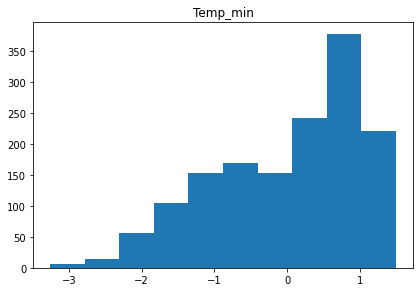

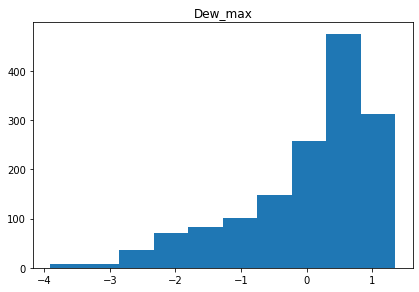

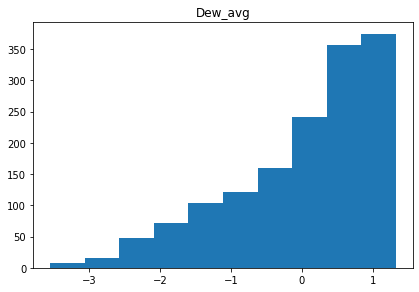

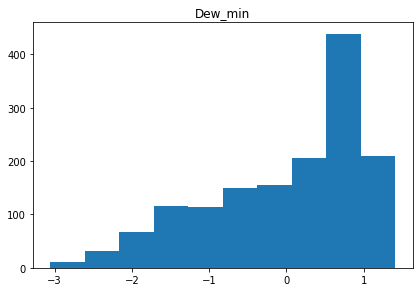

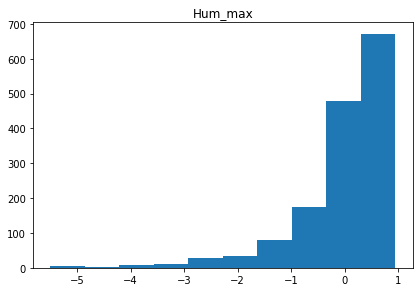

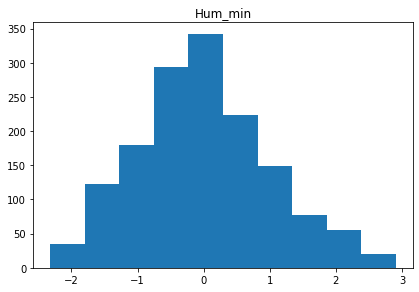

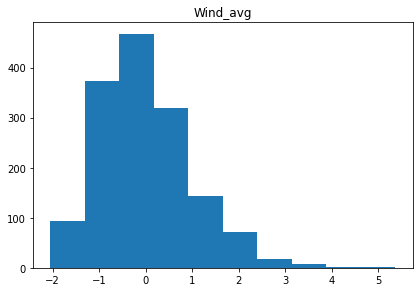

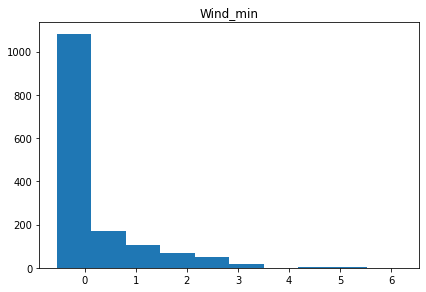

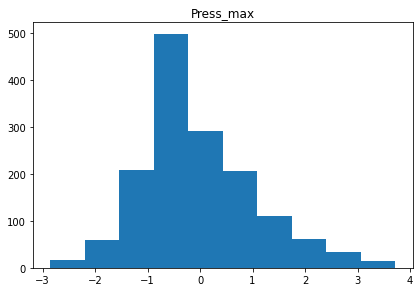

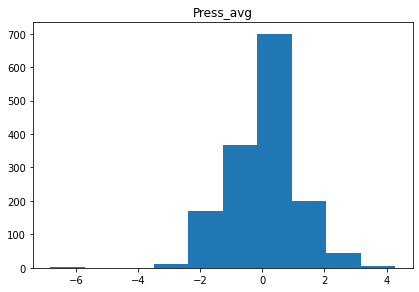

In [579]:
for feature in columns[2:-2]:
  fig, ax = plt.subplots()
  fig.tight_layout()
  ax.hist(x=df_cons_pred[feature])
  ax.set_title(feature)

In [580]:
#df_cons_pred['Dew_avg2'] = np.log10(df_cons_pred['Dew_avg'] + 1)
#fig, ax = plt.subplots()
#fig.tight_layout()
#ax.hist(x=df_cons_pred['Dew_avg2'])
#ax.set_title('Dew_avg2')

##Feature engineering

In [581]:
df_cons_pred['day'] = df_cons_pred.Date.dt.day
df_cons_pred['day_of_week'] = df_cons_pred.Date.dt.day_of_week
df_cons_pred['month'] = df_cons_pred.Date.dt.month
df_cons_pred['year'] = df_cons_pred.Date.dt.year
df_cons_pred.drop(columns='Date', inplace=True)

In [582]:
df_cons_pred.head()

,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_min,Wind_avg,Wind_min,Press_max,Press_avg,consumption,day,day_of_week,month,year
0,0.333147,0.283206,0.378948,0.626904,0.706502,0.623570,0.952177,0.865406,0.575666,-0.55311,-1.059787,-0.655278,29.691,6,2,1,2016
1,1.044725,1.095177,0.972040,0.788916,0.896551,1.017681,0.177612,-0.025576,-0.688091,-0.55311,-0.462061,-0.037915,43.177,7,3,1,2016
2,1.281918,1.223806,0.897904,0.788916,0.845384,0.689255,0.435800,-0.916557,-0.588321,-0.55311,0.135665,-0.037915,50.057,8,4,1,2016
3,1.202853,1.199688,1.120313,0.707910,0.845384,0.886311,-0.596953,-0.343783,-0.488550,-0.55311,-1.059787,-0.655278,47.363,9,5,1,2016
4,0.016890,-0.014249,-0.140008,-0.183156,-0.170648,0.032404,-0.338764,-0.407425,-1.486254,-0.55311,0.135665,-0.037915,42.203,10,6,1,2016


In [354]:
# Definindo a função Dummies
def dummies(x,df):
    
    #cria um dataframe temporario com o resultado do processo One-hot Encode e deletando a primeira coluna
    temp = pd.get_dummies(df[x], drop_first = True)
    
    #concatena o dataframe df com o temporario
    df = pd.concat([df, temp], axis = 1)
    
    #exclui a coluna referente ao atributo x
    df = df.drop(columns = x)
    
    return df

In [355]:
var_categ = ['Day',	'day_of_week',	'month',	'year']

In [356]:
#aplica a função dummies para os atributos categoricos
for var in var_categ:
    df_cons_pred = dummies(var,df_cons_pred)

In [207]:
df_cons_pred.head()

,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_min,Wind_avg,Wind_min,...,7,8,9,10,11,12,2017,2018,2019,2020
0,85,74.8,68,74,71.4,66,100,65,9.5,0,...,0,0,0,0,0,0,0,0,0,0
1,94,84.9,76,76,74.0,72,94,51,5.7,0,...,0,0,0,0,0,0,0,0,0,0
2,97,86.5,75,76,73.3,67,96,37,6.0,0,...,0,0,0,0,0,0,0,0,0,0
3,96,86.2,78,75,73.3,70,88,46,6.3,0,...,0,0,0,0,0,0,0,0,0,0
4,81,71.1,61,64,59.4,57,90,45,3.3,0,...,0,0,0,0,0,0,0,0,0,0


##Testes

In [348]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from sklearn.metrics import r2_score

In [357]:
X = df_cons_pred.drop(columns=['consumption'])
y = df_cons_pred.consumption

In [358]:
X_columns = X.columns

In [359]:
scaler = StandardScaler()

In [360]:
X = StandardScaler().fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [361]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [362]:
LM = LinearRegression()

In [363]:
LM.fit(X_train, y_train)

LinearRegression()

In [364]:
r2_score(y_test, LM.predict(X_test))

0.6543859367757077

In [215]:
RFR = RandomForestRegressor()

In [365]:
RFR.fit(X_train, y_train)

RandomForestRegressor()

In [366]:
r2_score(y_test, RFR.predict(X_test))

0.7741735388691082

In [220]:
Lasso = LassoCV()

In [221]:
Lasso.fit(X_train, y_train)

LassoCV()

In [224]:
Lasso.score(X_test, y_test)

0.6531843099160066

In [225]:
Lasso.coef_

array([ 1.62950818e+00,  1.36856332e+00,  3.79573255e+00, -0.00000000e+00,
        0.00000000e+00,  3.47696957e-01, -7.79850448e-02, -1.36673268e+00,
       -2.61231026e-01,  0.00000000e+00,  1.18639528e-03,  3.71430875e-01,
       -2.71822929e-01, -8.43836052e-01, -7.34215550e-01, -2.71053709e-01,
        8.79148952e-01,  1.40723107e+00,  1.11522649e+00,  2.90304265e-01,
        7.57998881e-01, -4.17229451e-01, -2.83992461e-01,  3.78951757e-01,
        3.65027501e-01,  4.16472278e-01,  0.00000000e+00,  2.09344331e-02,
        1.51400807e-01,  0.00000000e+00,  1.66839573e-01, -0.00000000e+00,
       -0.00000000e+00, -1.60642533e-01, -2.45552484e-01, -3.16762755e-01,
       -4.21439028e-01, -1.83254977e-01, -0.00000000e+00, -7.32814077e-02,
        0.00000000e+00, -0.00000000e+00, -7.95579786e-02, -0.00000000e+00,
        3.36357009e-02, -7.17972798e-02,  1.65491816e-01,  1.77901961e-01,
       -3.04499788e-01, -8.43050914e-01, -4.95489944e-01,  3.62159578e-02,
        1.21256589e+00,  

In [235]:
#print das features e seus respectivos p-value
for value in [*zip(X_columns, Lasso.coef_)]:
  print(value)

('Temp_max', 1.6295081838911252)
('Temp_avg', 1.3685633194197984)
('Temp_min', 3.795732553719301)
('Dew_max', -0.0)
('Dew_avg', 0.0)
('Dew_min', 0.34769695655784766)
('Hum_max', -0.07798504478690281)
('Hum_min', -1.3667326796486703)
('Wind_avg', -0.26123102630725314)
('Wind_min', 0.0)
('Press_max', 0.0011863952800133483)
('Press_avg', 0.3714308750419818)
(2, -0.27182292947469583)
(3, -0.8438360515256619)
(4, -0.7342155503711952)
(5, -0.2710537093435635)
(6, 0.8791489522392015)
(7, 1.407231070078969)
(8, 1.1152264902716942)
(9, 0.2903042646868856)
(10, 0.7579988805646224)
(11, -0.4172294512175706)
(12, -0.2839924611558189)
(13, 0.3789517572274063)
(14, 0.36502750117330346)
(15, 0.41647227829388556)
(16, 0.0)
(17, 0.020934433088997197)
(18, 0.1514008065543257)
(19, 0.0)
(20, 0.16683957336808097)
(21, -0.0)
(22, -0.0)
(23, -0.16064253302823323)
(24, -0.2455524841857677)
(25, -0.31676275541319304)
(26, -0.4214390275019427)
(27, -0.18325497695025608)
(28, -0.0)
(29, -0.0732814076981772)
(30

In [236]:
Ridge = RidgeCV()

In [237]:
Ridge.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [238]:
Ridge.score(X_test, y_test)

0.6548278236760655